# Xarray-spatial
### User Guide: Surface tools
-----
With the Surface tools, you can quantify and visualize a terrain landform represented by a digital elevation model.

Starting with a raster elevation surface that represented as an Xarray DataArray, these tools help you in identifying some specific patterns that were not readily apparent in the original surface. Return of each function is also an Xarray DataArray.

[Hillshade](#Hillshade): Creates a shaded relief from a surface raster by considering the illumination source angle and shadows.

[Slope](#Slope): Identifies the slope from each cell of a raster.

[Curvature](#Curvature): Calculates the curvature of a raster surface.

[Aspect](#Aspect): Derives the aspect from each cell of a raster surface.

[Viewshed](#Viewshed): Determines visible locations in the input raster surface from a viewpoint with some optional observer features.

-----------


#### Let's use datashader to render our images...

In [1]:
import numpy as np
import datashader as ds
from datashader.transfer_functions import shade
from datashader.transfer_functions import stack
from datashader.transfer_functions import dynspread
from datashader.transfer_functions import set_background
from datashader.colors import Elevation
import pandas as pd

import xrspatial

## Generate Terrain Data

The rest of the geo-related functions focus on raster data (or rasterized data, after a previous Datashader step that returns an Xarray object). To demonstrate using these raster-based functions, let's generate some fake terrain as an elevation raster:

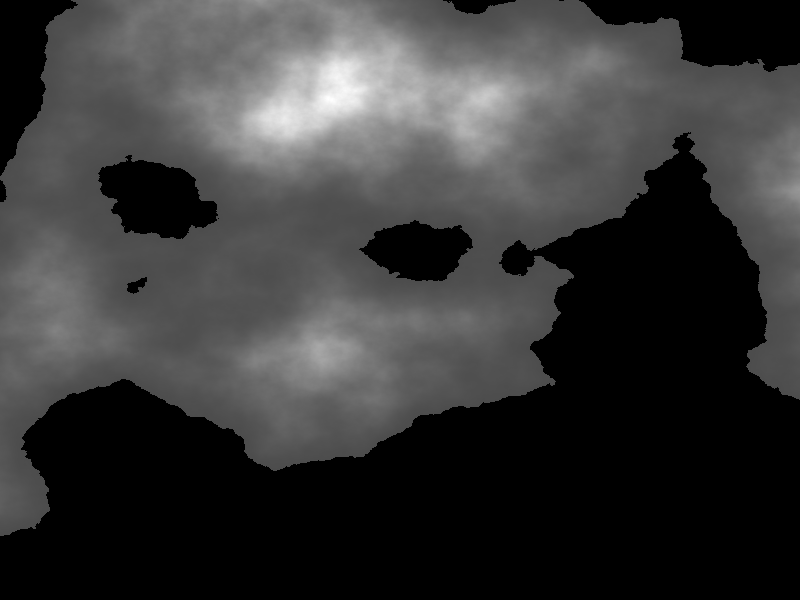

In [2]:
from xrspatial import generate_terrain

W = 800
H = 600

cvs = ds.Canvas(plot_width=W, plot_height=H, x_range=(-20e6, 20e6), y_range=(-20e6, 20e6))
terrain = generate_terrain(canvas=cvs)

shade(terrain, cmap=['black', 'white'], how='linear')

The grayscale value above shows the elevation linearly in intensity (with the large black areas indicating low elevation), but it will look more like a landscape if we map the lowest values to colors representing water, and the highest to colors representing mountaintops:

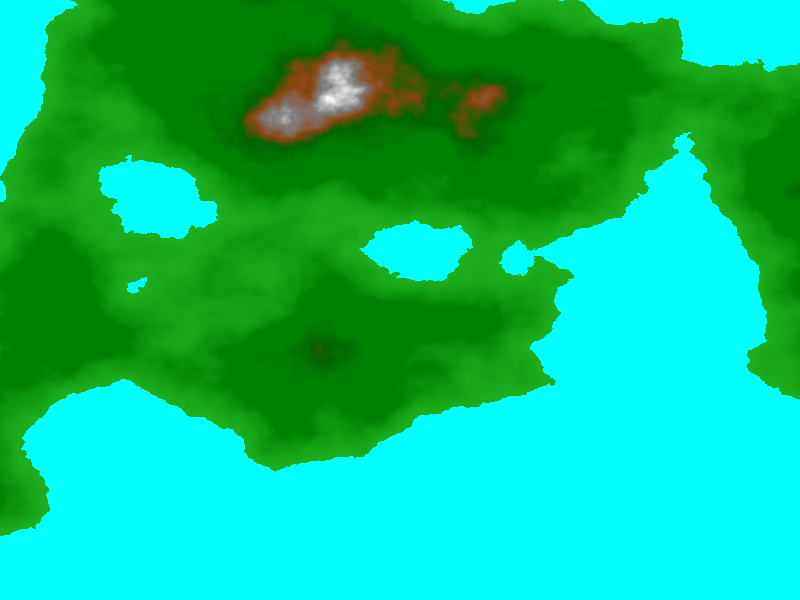

In [3]:
shade(terrain, cmap=Elevation, how='linear')

## Hillshade

[Hillshade](https://en.wikipedia.org/wiki/Terrain_cartography) is a technique used to visualize terrain as shaded relief, illuminating it with a hypothetical light source. The illumination value for each cell is determined by its orientation to the light source, which is based on slope and aspect.

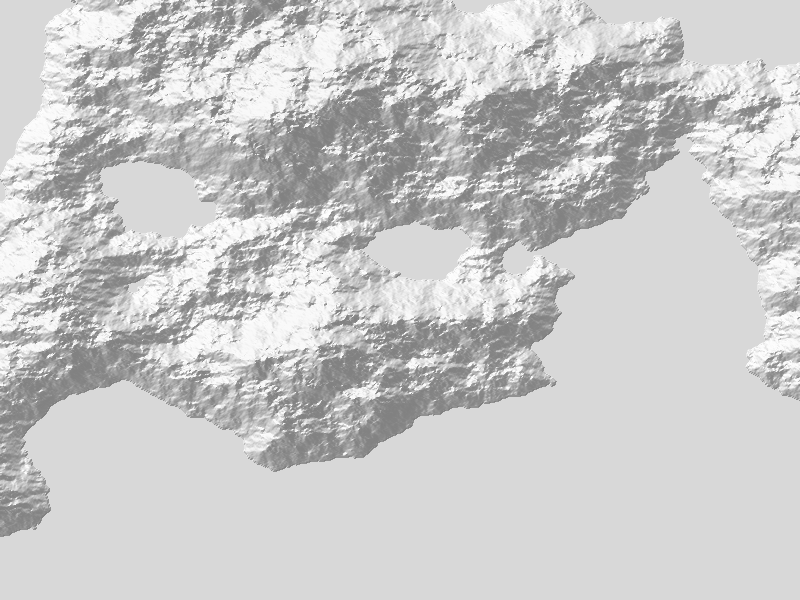

In [4]:
from xrspatial import hillshade

illuminated = hillshade(terrain)

shade(illuminated, cmap=['gray', 'white'], alpha=255, how='linear')

You can combine hillshading with elevation colormapping to convey differences in terrain with elevation:

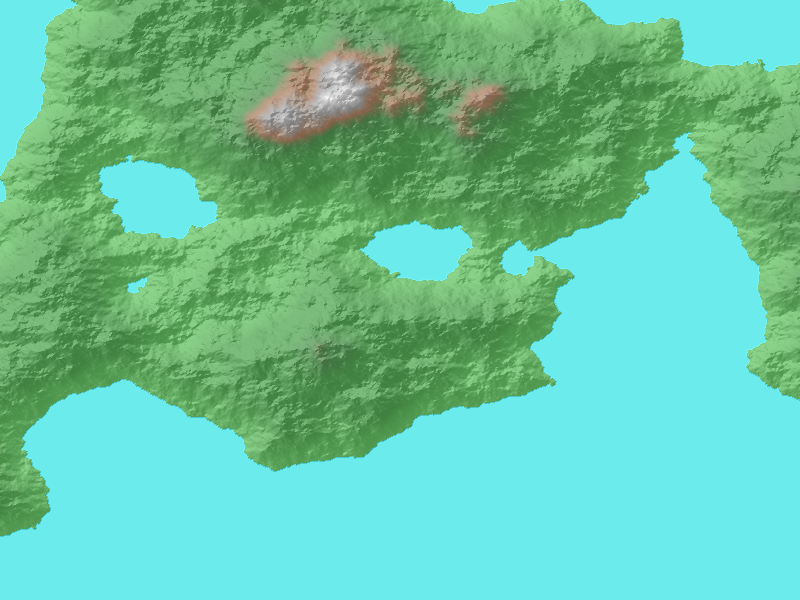

In [5]:
stack(shade(illuminated, cmap=['gray', 'white'], alpha=255, how='linear'),
      shade(terrain,     cmap=Elevation,         alpha=128, how='linear'))

## Slope
[Slope](https://en.wikipedia.org/wiki/Slope) is the inclination of a surface. 
In geography, *slope* is amount of change in elevation of a terrain regarding its surroundings.

Datashader's slope function returns slope in degrees.  Below we highlight areas at risk for avalanche by looking at [slopes around 38 degrees](http://wenatcheeoutdoors.org/2016/04/07/avalanche-abcs-for-snowshoers/).

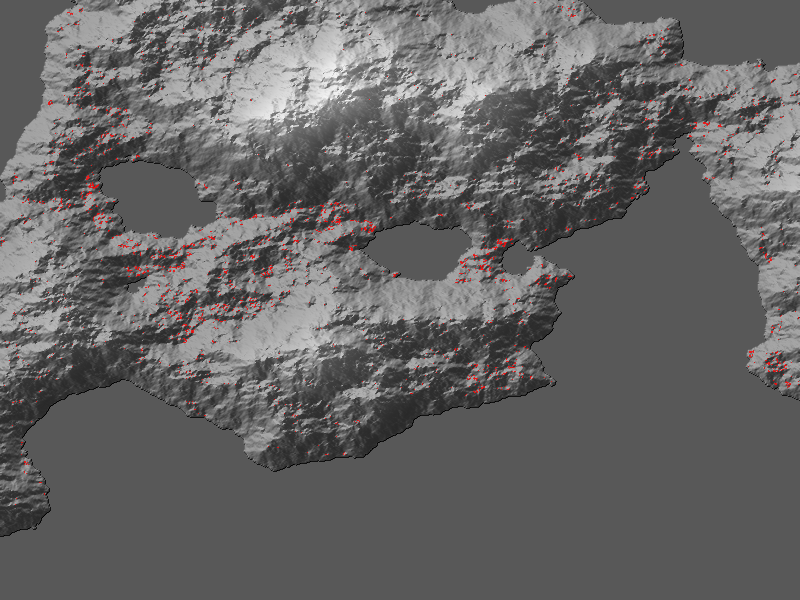

In [6]:
from xrspatial import slope

risky = slope(terrain)
risky.data = np.where(np.logical_and(risky.data > 25, risky.data < 50), 1, np.nan)

stack(shade(terrain,     cmap=['black', 'white'], how='linear'),
      shade(illuminated, cmap=['black', 'white'], how='linear', alpha=128),
      shade(risky,       cmap='red',              how='linear', alpha=200))

## Curvature
[Curvature](https://desktop.arcgis.com/en/arcmap/10.3/tools/spatial-analyst-toolbox/curvature.htm) is the second derivative of the surface, or the slope-of-the-slope.
- A positive curvature indicates the surface is upwardly convex at that cell. 
- A negative curvature indicates the surface is upwardly concave at that cell. 
- A value of 0 indicates the surface is flat.

Units of the curvature output raster are one hundredth (1/100) of a z-unit. The reasonably expected values of all three output rasters for a hilly area (moderate relief) can vary from -0.5 to 0.5; while for steep, rugged mountains (extreme relief), the values can vary between -4 and 4. Note that it is possible to exceed this range for certain raster surfaces.

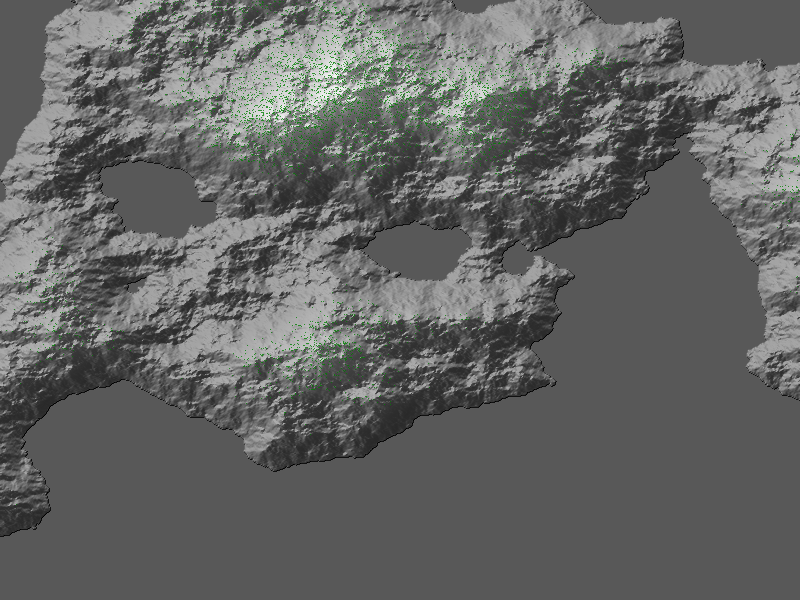

In [7]:
from xrspatial import curvature

curv = curvature(terrain)

curv.data = np.where(np.logical_and(curv.data > 1e-06, curv.data < 2e-06), 1, np.nan)

stack(shade(terrain,     cmap=['black', 'white'], how='linear'),
      shade(illuminated, cmap=['black', 'white'], how='linear', alpha=128),
      shade(curv,        cmap='green',              how='linear', alpha=200))

## Aspect

[Aspect](https://en.wikipedia.org/wiki/Aspect_(geography)) is the orientation of slope, measured clockwise in degrees from 0 to 360, where 0 is north-facing, 90 is east-facing, 180 is south-facing, and 270 is west-facing.

Below, we look to find slopes that face close to North.

C:\Users\mdo\Anaconda3\envs\xarray-spatial\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in greater
  after removing the cwd from sys.path.
C:\Users\mdo\Anaconda3\envs\xarray-spatial\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in less
  """


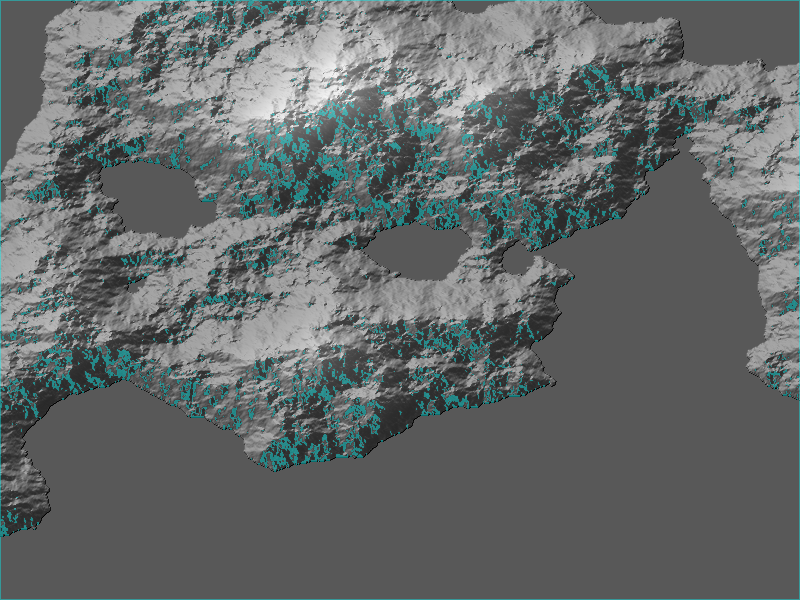

In [8]:
from xrspatial import aspect

north_faces = aspect(terrain)
north_faces.data = np.where(np.logical_or(north_faces.data > 350 ,
                                          north_faces.data < 10), 1, np.nan)

stack(shade(terrain,     cmap=['black', 'white'], how='linear'),
      shade(illuminated, cmap=['black', 'white'], how='linear', alpha=128),
      shade(north_faces, cmap=['aqua'],           how='linear', alpha=100))

## Viewshed

The `xrspatial.viewshed` function operates on a given aggregate to calculate the viewshed (the visible cells in the raster) for the given viewpoint (observer) location.  

The visibility model is the following: Two cells are visible to each other if the line of sight that connects their centers does not intersect the terrain. If the line of sight does not pass through the cell center, elevation is determined using bilinear interpolation.

##### Simple Viewshed Example

- The example below creates a datashader aggregate from a 2d normal distribution.
- To calculate the viewshed, we need an observer location.
- This location is indicated by the orange point in the upper-left of the plot.

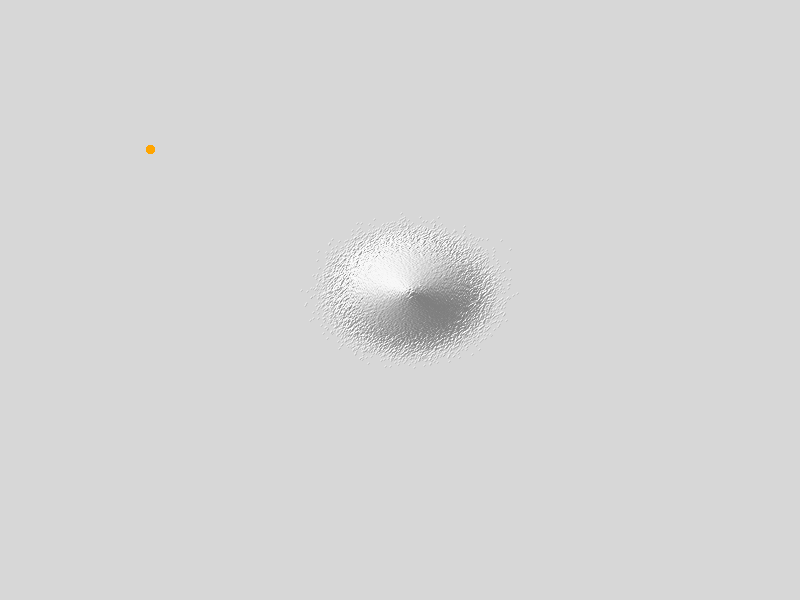

In [9]:
from xrspatial import viewshed

OBSERVER_X = -12.5
OBSERVER_Y = 10

canvas = ds.Canvas(plot_width=W, plot_height=H,
                   x_range=(-20, 20), y_range=(-20, 20))

normal_df = pd.DataFrame({
   'x': np.random.normal(.5, 1, 10000000),
   'y': np.random.normal(.5, 1, 10000000)
})
normal_agg = canvas.points(normal_df, 'x', 'y')
normal_agg.values = normal_agg.values.astype("float64")
normal_shaded = shade(normal_agg)

observer_df = pd.DataFrame({'x': [OBSERVER_X], 'y': [OBSERVER_Y]})
observer_agg = canvas.points(observer_df, 'x', 'y')
observer_shaded = dynspread(shade(observer_agg, cmap=['orange']),
                            threshold=1, max_px=4)

normal_illuminated = hillshade(normal_agg)
normal_illuminated_shaded = shade(normal_illuminated, cmap=['black', 'white'], 
                                  alpha=128, how='linear')

stack(normal_illuminated_shaded, observer_shaded)

##### Calculate viewshed using the observer location

Wall time: 3.35 s


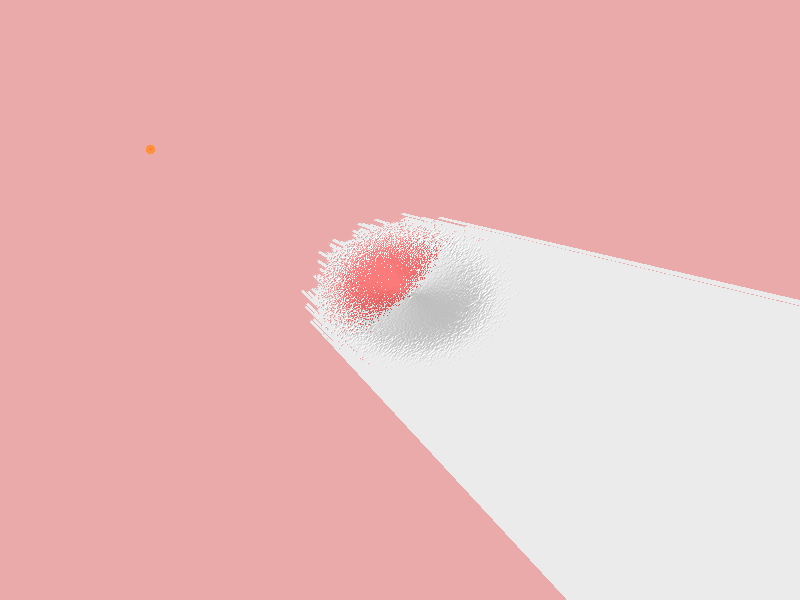

In [10]:
# Will take some time to run...
%time view = viewshed(normal_agg, x=OBSERVER_X, y=OBSERVER_Y)

view_shaded = shade(view, cmap=['white', 'red'], alpha=128, how='linear')

stack(normal_illuminated_shaded, observer_shaded, view_shaded)                         

##### Viewshed on Terrain

- Let's take the example above and apply it to our terrain aggregate.
- Notice the use of the `observer_elev` argument, which is the height of the observer above the terrain.

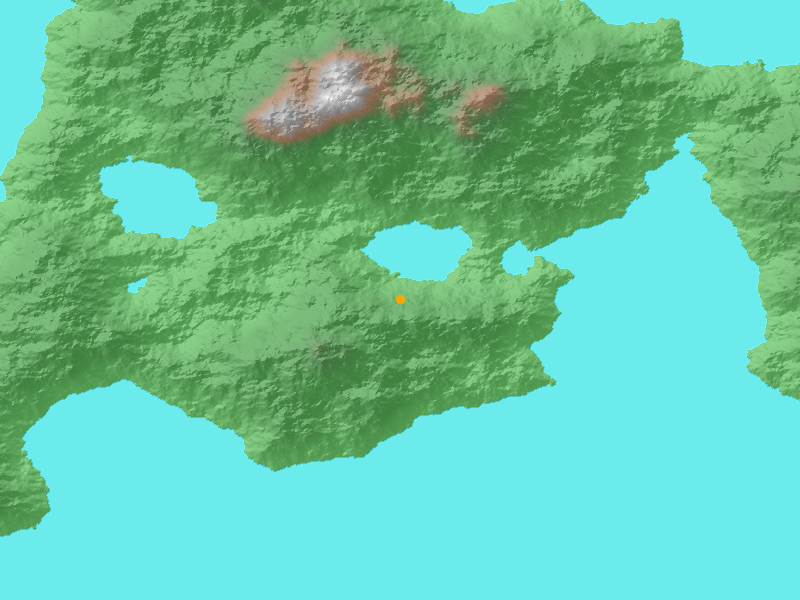

In [11]:
from xrspatial import viewshed


cvs = ds.Canvas(plot_width=W, plot_height=H, x_range=(-20e6, 20e6), y_range=(-20e6, 20e6))
terrain = generate_terrain(canvas=cvs)
terrain_shaded = shade(terrain, cmap=Elevation, alpha=128, how='linear')

illuminated = hillshade(terrain)

OBSERVER_X = 0.0
OBSERVER_Y = 0.0

observer_df = pd.DataFrame({'x': [OBSERVER_X],'y': [OBSERVER_Y]})
observer_agg = cvs.points(observer_df, 'x', 'y')
observer_shaded = dynspread(shade(observer_agg, cmap=['orange']),
                            threshold=1, max_px=4)

stack(shade(illuminated, cmap=['black', 'white'], alpha=128, how='linear'),
      terrain_shaded,
      observer_shaded)

Wall time: 1.31 s


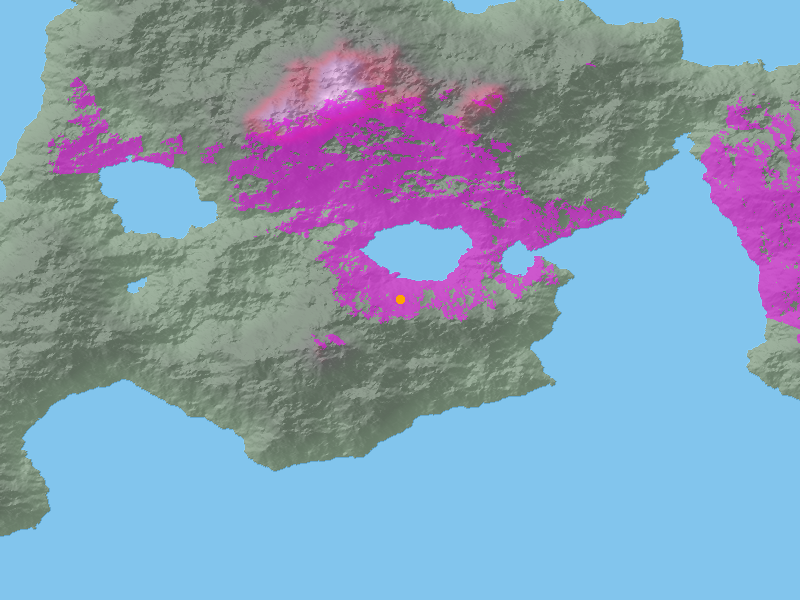

In [12]:
%time view = viewshed(terrain, x=OBSERVER_X, y=OBSERVER_Y, observer_elev=100)

view_shaded = shade(view, cmap='fuchsia', how='linear')
stack(shade(illuminated, cmap=['black', 'white'], alpha=128, how='linear'),
      terrain_shaded,
      view_shaded,
      observer_shaded)

The fuchsia areas are those visible to an observer of the given height at the indicated orange location.




### References
- An overview of the Surface toolset: https://pro.arcgis.com/en/pro-app/tool-reference/spatial-analyst/an-overview-of-the-surface-tools.htm
- Burrough, P. A., and McDonell, R. A., 1998. Principles of Geographical Information Systems (Oxford University Press, New York), p. 406.
- Making Maps with Noise Functions: https://www.redblobgames.com/maps/terrain-from-noise/
- How Aspect Works: http://desktop.arcgis.com/en/arcmap/10.3/tools/spatial-analyst-toolbox/how-aspect-works.htm#ESRI_SECTION1_4198691F8852475A9F4BC71246579FAA